In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from tensorflow.keras import Model, layers, models, optimizers, regularizers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed, Input
import seaborn as sns

In [2]:
lotto = pd.read_excel('로또.xlsx')
lotto = lotto.sort_values(by='회차').reset_index(drop=True)
numlist = lotto.columns[1:8]

In [3]:
for i in range(len(numlist)):
    globals()[f'num{i + 1}']= lotto[numlist[i]]

In [4]:
step = 10

def trans_sequences(df, step):
    temp = []
    for i in range(len(df)-step+1):
        temp.append(df.iloc[i:(i+step)].values)
    
    return np.array(temp)

In [7]:
lotto_seq = trans_sequences(lotto[numlist], step)

In [8]:
train_number = lotto_seq.shape[0]
feature_number = lotto_seq.shape[2]

In [19]:
train = lotto_seq[:int(len(lotto_seq)*0.7), :, :]
test = lotto_seq[int(len(lotto_seq)*0.7):, :, :]

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 7)]           0         
                                                                 
 lstm (LSTM)                 (None, 10, 32)            5120      
                                                                 
 dropout (Dropout)           (None, 10, 32)            0         
                                                                 
 lstm_1 (LSTM)               (None, 16)                3136      
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 repeat_vector (RepeatVector  (None, 10, 16)           0         
 )                                                 

2022-06-12 13:04:28.651054: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-12 13:04:28.651223: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


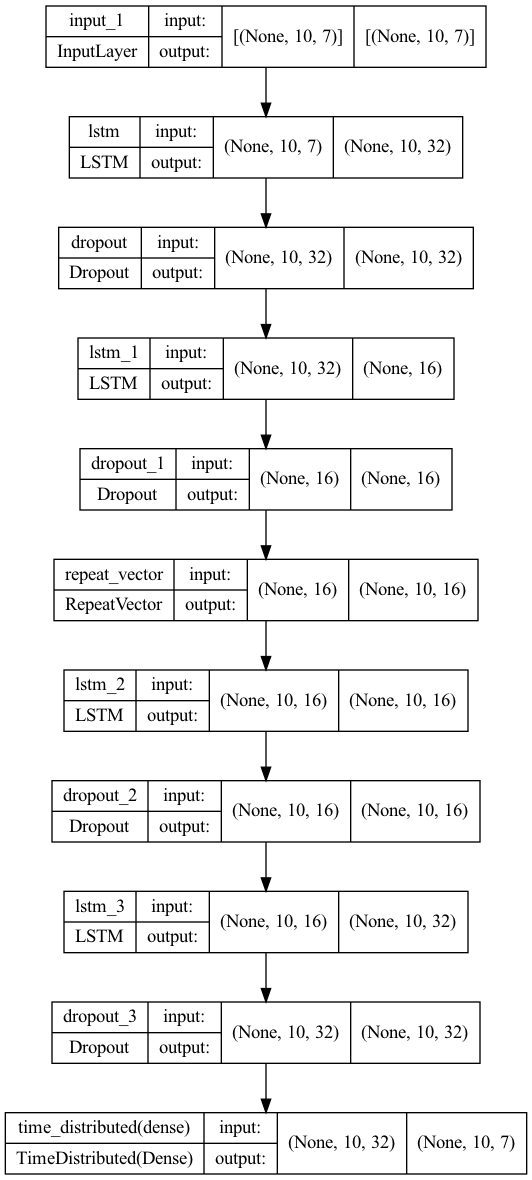

In [9]:
# encoder
pre_input = Input(shape=(step,feature_number))
encoder = LSTM(32, activation='swish', return_sequences=True)(pre_input)
encoder = Dropout(.1)(encoder)
encoder = LSTM(16, activation='swish', return_sequences=False)(encoder)
encoder = Dropout(.1)(encoder)

# reconstruct decoder
decoder1 = RepeatVector(step)(encoder)
decoder1 = LSTM(16, activation='swish', return_sequences=True)(decoder1)
decoder1 = Dropout(.1)(decoder1)
decoder1 = LSTM(32, activation='swish', return_sequences=True)(decoder1)
decoder1 = Dropout(.1)(decoder1)
decoder1 = TimeDistributed(Dense(feature_number))(decoder1)

# tie
lstm_autoencoder = Model(inputs=pre_input, outputs=decoder1)
lstm_autoencoder.summary()
lstm_autoencoder.compile(optimizer='adam', loss='mse')
plot_model(lstm_autoencoder, show_shapes=True)

In [20]:
history = lstm_autoencoder.fit(train[:-1, :, :], train[1:, :, :], epochs=100, batch_size=32, validation_split=0.2)

Epoch 1/100


2022-06-12 13:08:45.415463: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-06-12 13:08:46.368646: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - ETA: 0s - loss: 638.4502

2022-06-12 13:08:56.916241: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 12s 544ms/step - loss: 638.4502 - val_loss: 513.8009
Epoch 2/100
18/18 [==============================] - 9s 510ms/step - loss: 491.3699 - val_loss: 331.6288
Epoch 3/100
18/18 [==============================] - 9s 514ms/step - loss: 389.3040 - val_loss: 269.6972
Epoch 4/100
18/18 [==============================] - 9s 519ms/step - loss: 311.3957 - val_loss: 211.5154
Epoch 5/100
18/18 [==============================] - 9s 523ms/step - loss: 258.6322 - val_loss: 175.1801
Epoch 6/100
18/18 [==============================] - 9s 515ms/step - loss: 220.1614 - val_loss: 157.0875
Epoch 7/100
18/18 [==============================] - 9s 523ms/step - loss: 179.1924 - val_loss: 140.7878
Epoch 8/100
18/18 [==============================] - 10s 536ms/step - loss: 156.4453 - val_loss: 115.2903
Epoch 9/100
18/18 [==============================] - 10s 544ms/step - loss: 137.1526 - val_loss: 107.0692
Epoch 10/100
18/18 [==============================] - 10s 554ms/

In [52]:
predicted = lstm_autoencoder.predict(test[:, :, :])

In [53]:
test[-1, 9, :].tolist()

[1, 4, 13, 17, 34, 39, 6]

In [66]:
predicted[-1, 9, :].tolist()

[5.751946926116943,
 11.602001190185547,
 18.227108001708984,
 23.1426944732666,
 29.0788516998291,
 34.7099723815918,
 19.666534423828125]